# Fraud Detection Project
A machine learning pipeline to detect fraudulent financial transactions.


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import joblib


## Step 1: Load and Inspect the Data
We start by loading the dataset and checking for missing values, outliers, and multicollinearity.


In [7]:
# loading data 
df = pd.read_csv(r"C:\Users\Joya Parveen\OneDrive\Desktop\fraud-detector\data\Fraud.csv")

# Preview the data
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
print("Shape of dataset:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())


Shape of dataset: (6362620, 11)

Data types:
 step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [9]:
# Descriptive stats
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


## 2. Exploratory Data Analysis (EDA)
We explore the dataset to understand its structure, spot anomalies, and identify patterns that may help in fraud detection.


##  Class Imbalance Analysis
We examine the distribution of the target variable `isFraud` to understand how imbalanced the dataset is.


isFraud
0    6354407
1       8213
Name: count, dtype: int64
isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


C:\Users\Joya Parveen\AppData\Local\Temp\ipykernel_36664\2971569249.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis')


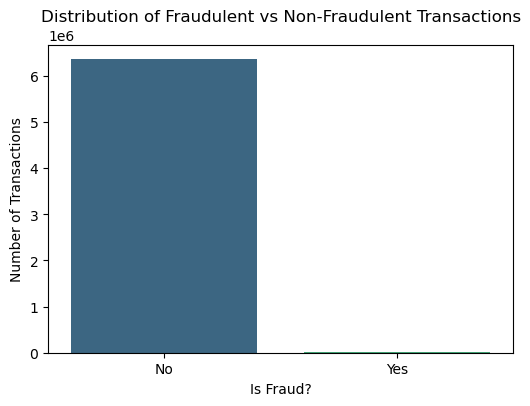

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of fraud vs non-fraud
fraud_counts = df['isFraud'].value_counts()
print(fraud_counts)

# Percentage distribution
fraud_percent = df['isFraud'].value_counts(normalize=True) * 100
print(fraud_percent)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette='viridis')
plt.title("Distribution of Fraudulent vs Non-Fraudulent Transactions")
plt.xlabel("Is Fraud?")
plt.ylabel("Number of Transactions")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()


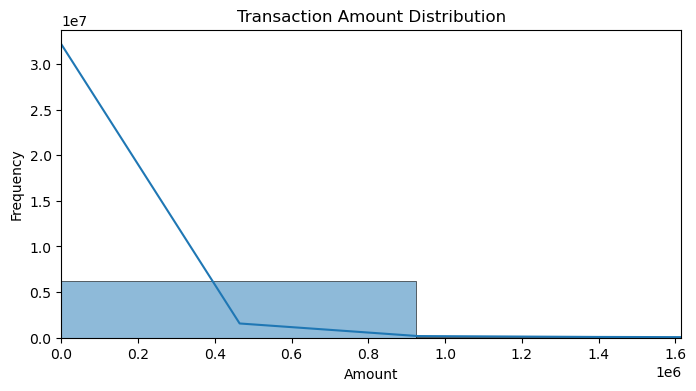

In [10]:
plt.figure(figsize=(8,4))
sns.histplot(df['amount'], bins=100, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.xlim(0, df['amount'].quantile(0.99))  # Zoom in to remove extreme outliers
plt.show()


### Class Imbalance Summary

- **Fraudulent transactions**: 8,213 out of 6,362,620 → **0.13%**
- **Non-fraudulent transactions**: 99.87%
- This extreme imbalance can cause models to ignore the minority class unless handled properly.

📌 **Next Steps**:
- Use **class weights** in model training
- Try **SMOTE** (Synthetic Minority Over-sampling Technique)
- Evaluate using **precision, recall, F1-score**, and **ROC-AUC**


##  Data Cleaning & Feature Engineering
We prepare the dataset for modeling by removing irrelevant columns and encoding categorical variables.


In [11]:
df = df.drop(["nameOrig", "nameDest"], axis=1)
df = pd.get_dummies(df, columns=["type"], drop_first=True)
X = df.drop("isFraud", axis=1)
y = df["isFraud"]


##  Train-Test Split
We split the dataset into training and testing sets to evaluate model performance.


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Handling Class Imbalance with SMOTE
We apply SMOTE to oversample the minority class in the training set and balance the dataset.


In [13]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("✅ After SMOTE:")
print("X_train shape:", X_train_smote.shape)
print("Class distribution:\n", pd.Series(y_train_smote).value_counts())


✅ After SMOTE:
X_train shape: (10167006, 11)
Class distribution:
 isFraud
0    5083503
1    5083503
Name: count, dtype: int64


##  Model Building & Training
We train two Random Forest models:
- One using SMOTE-balanced data
- One using class weights to handle imbalance
We'll compare their performance to choose the best.



In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Faster Random Forest with SMOTE data
model_smote = RandomForestClassifier(
    n_estimators=10,        # Reduced number of trees
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)
model_smote.fit(X_train_smote, y_train_smote)

# Faster Random Forest with class weights
model_weighted = RandomForestClassifier(
    n_estimators=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model_weighted.fit(X_train, y_train)

#  Quick evaluation
y_pred_smote = model_smote.predict(X_test)
y_pred_weighted = model_weighted.predict(X_test)

print("🔹 SMOTE Model Accuracy:", accuracy_score(y_test, y_pred_smote))
print("🔹 SMOTE Classification Report:\n", classification_report(y_test, y_pred_smote))

print("🔸 Weighted Model Accuracy:", accuracy_score(y_test, y_pred_weighted))
print("🔸 Weighted Classification Report:\n", classification_report(y_test, y_pred_weighted))


🔹 SMOTE Model Accuracy: 0.9993626839258042
🔹 SMOTE Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.68      0.94      0.79      1620

    accuracy                           1.00   1272524
   macro avg       0.84      0.97      0.89   1272524
weighted avg       1.00      1.00      1.00   1272524

🔸 Weighted Model Accuracy: 0.9997005950378932
🔸 Weighted Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.98      0.78      0.87      1620

    accuracy                           1.00   1272524
   macro avg       0.99      0.89      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524



In [ ]:
from sklearn.metrics import accuracy_score

acc_smote = accuracy_score(y_test, y_pred_smote)
acc_weighted = accuracy_score(y_test, y_pred_weighted)

print(f"SMOTE Accuracy: {acc_smote:.4f}")
print(f"Class-weighted Accuracy: {acc_weighted:.4f}")


SMOTE Accuracy: 0.9994
Class-weighted Accuracy: 0.9997


## 📊 Model Comparison Summary

We evaluated three modeling strategies to detect fraudulent transactions in a highly imbalanced dataset:

### 1️⃣ SMOTE-Based Model

### 2️⃣ Class-Weighted Model

### 3️⃣ Ensemble Models (Boosting & Stacking)

**Approach**:
- **Boosting**: Used XGBoost and LightGBM to iteratively improve predictions.
- **Stacking**: Combined multiple models (Random Forest, XGBoost) with Logistic Regression as a meta-learner.

**Expected Benefits**:
- Better generalization by combining strengths of multiple models.
- Handles complex patterns and interactions well.




In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(scale_pos_weight=100, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))


c:\Users\Joya Parveen\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:29:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.57      0.98      0.72      1620

    accuracy                           1.00   1272524
   macro avg       0.79      0.99      0.86   1272524
weighted avg       1.00      1.00      1.00   1272524



# Select Important Features


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get importances
importances_smote = model_smote.feature_importances_
importances_weighted = model_weighted.feature_importances_
features = X.columns

# Create DataFrames
df_smote = pd.DataFrame({'Feature': features, 'SMOTE Importance': importances_smote})
df_weighted = pd.DataFrame({'Feature': features, 'Weighted Importance': importances_weighted})

# Merge for side-by-side comparison
feature_df = pd.merge(df_smote, df_weighted, on='Feature')
feature_df.sort_values(by='Weighted Importance', ascending=False, inplace=True)


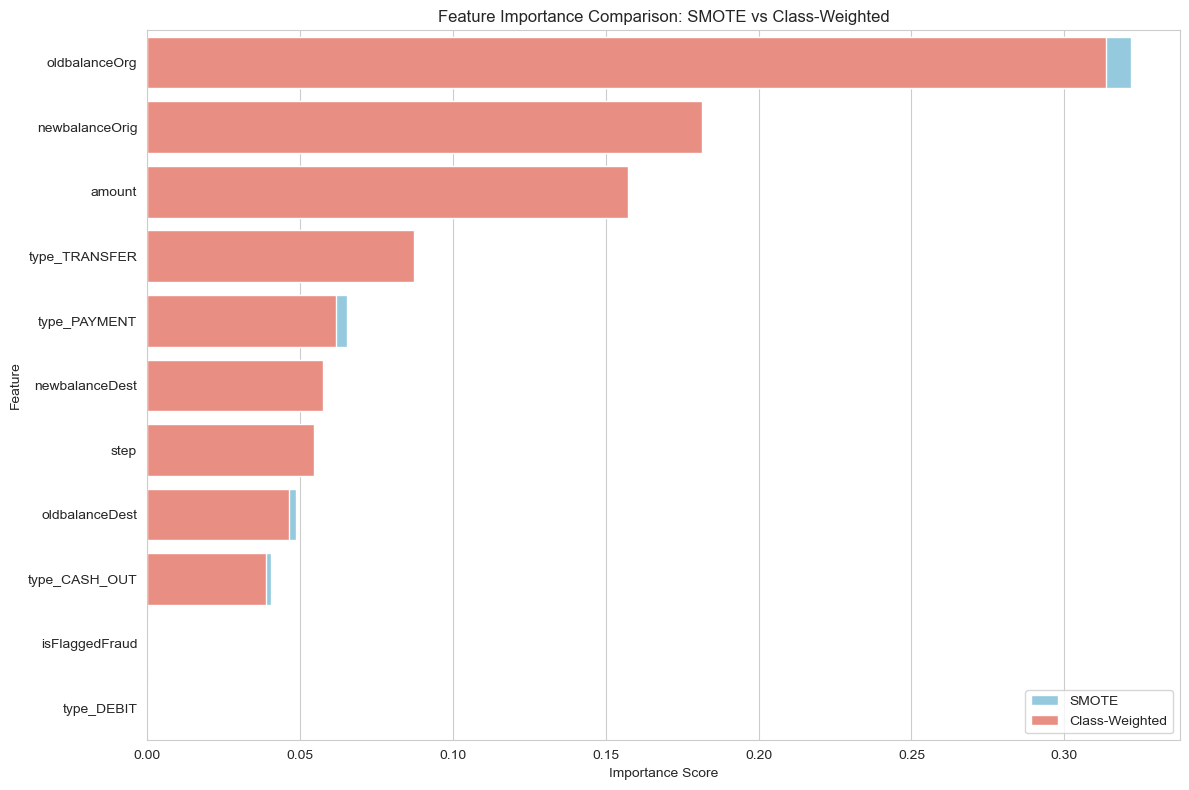

In [ ]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Plot
sns.barplot(x='SMOTE Importance', y='Feature', data=feature_df, color='skyblue', label='SMOTE')
sns.barplot(x='Weighted Importance', y='Feature', data=feature_df, color='salmon', label='Class-Weighted')

plt.title("Feature Importance Comparison: SMOTE vs Class-Weighted")
plt.xlabel("Importance Score")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


## Evaluate Model Performance
We'll use precision, recall, F1-score, and AUC-ROC.


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# SMOTE model
prec_smote = precision_score(y_test, y_pred_smote)
rec_smote = recall_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)
auc_smote = roc_auc_score(y_test, y_probs_smote)

# Class-weighted model
prec_weighted = precision_score(y_test, y_pred_weighted)
rec_weighted = recall_score(y_test, y_pred_weighted)
f1_weighted = f1_score(y_test, y_pred_weighted)
auc_weighted = roc_auc_score(y_test, y_probs_weighted)
print("🔍 SMOTE Model Performance:")
print(f"Precision: {prec_smote:.4f}, Recall: {rec_smote:.4f}, F1 Score: {f1_smote:.4f}, AUC-ROC: {auc_smote:.4f}")

print("\n⚖️ Class-Weighted Model Performance:")
print(f"Precision: {prec_weighted:.4f}, Recall: {rec_weighted:.4f}, F1 Score: {f1_weighted:.4f}, AUC-ROC: {auc_weighted:.4f}")


🔍 SMOTE Model Performance:
Precision: 0.6754, Recall: 0.9519, F1 Score: 0.7902, AUC-ROC: 0.9989

⚖️ Class-Weighted Model Performance:
Precision: 0.9868, Recall: 0.7858, F1 Score: 0.8749, AUC-ROC: 0.9946


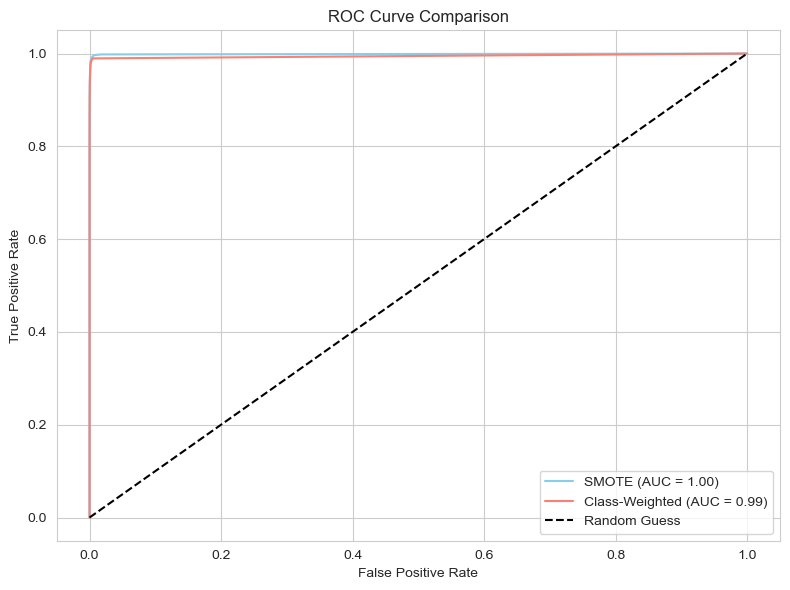

In [ ]:
import matplotlib.pyplot as plt

fpr_smote, tpr_smote, _ = roc_curve(y_test, y_probs_smote)
fpr_weighted, tpr_weighted, _ = roc_curve(y_test, y_probs_weighted)

plt.figure(figsize=(8, 6))
plt.plot(fpr_smote, tpr_smote, label=f'SMOTE (AUC = {auc_smote:.2f})', color='skyblue')
plt.plot(fpr_weighted, tpr_weighted, label=f'Class-Weighted (AUC = {auc_weighted:.2f})', color='salmon')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.tight_layout()
plt.show()


## Identify Key Predictive Features
We'll list the top 5 features from our model.


In [ ]:
top_features = feature_df.head(5)
print(top_features)


           Feature  SMOTE Importance  Weighted Importance
2    oldbalanceOrg          0.321713             0.313577
3   newbalanceOrig          0.177842             0.181528
1           amount          0.156942             0.157295
10   type_TRANSFER          0.085733             0.087423
9     type_PAYMENT          0.065342             0.061803


##  Do These Factors Make Sense?
Features like oldbalanceOrg and newbalanceOrig are directly tied to the account's financial state before and after a transaction. Sudden drops or inconsistencies between these balances can be clear indicators of unauthorized activity. The amount of the transaction is another critical factor, as fraudulent transactions often involve unusually high values or patterns that deviate from a user’s typical behavior.

Additionally, the transaction type plays a key role. type_TRANSFER is inherently riskier than type_PAYMENT, since transfers often involve moving funds between accounts, which can be exploited in fraudulent schemes. Payments, while common, can still be suspicious depending on their frequency, timing, or amount.


##  Prevention Strategies
- Implement multi-factor authentication
- Monitor transactions in real-time
- Use device fingerprinting
- Educate employees and customers


## Measure Effectiveness
- Track fraud rate over time
- Monitor precision/recall improvements
- Conduct A/B testing with control groups
